Name: Asmit Shrestha

Roll: 1928433

project name: Generative chatbot

**1) Importing the packages**


Importing TensorFlow and Keras. Also,imported other modules which help in defining model layers.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, activations, models, preprocessing
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import preprocessing, utils
from keras.regularizers import l1
import os, sys
import yaml
import re
import string

Using TensorFlow backend.


**2) Preprocessing the data**

**A) Downloading the dataset**

The dataset is downloaded from https://www.kaggle.com/kausr25/chatterbotenglishchatterbot/english on Kaggle.com. It contains pairs of questions and answers based on a number of subjects like food, history, AI etc.

**B) Reading the data from the files**

Here I parse each of the .yaml files.

-Concatenate two or more sentences if the answer has two or more of them.

-Remove unwanted data types which are produced while parsing the data.

-Append <START> and <END> to all the answers.
    
-Create a Tokenizer and load the whole vocabulary ( questions + answers ) into it.

In [2]:
dir_path = r'data'
files_list = os.listdir(dir_path + os.sep)

questions = list()
answers = list()

for filepath in files_list:
    stream = open( dir_path + os.sep + filepath , 'rb')
    docs = yaml.safe_load(stream)
    conversations = docs['conversations']
    for con in conversations:
        if len( con ) > 2 :
            questions.append(con[0])
            replies = con[ 1 : ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append( ans )
        elif len( con )> 1:
            questions.append(con[0])
            answers.append(con[1])

answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append( '<START> ' + answers_with_tags[i] + ' <END>' )





In [3]:

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))


VOCAB SIZE : 2456


In [4]:

vocab = []
for word in tokenizer.word_index:
    vocab.append( word )

def tokenize( sentences ):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        sentence = str(sentence).lower()
        sentence = re.sub( '[^a-zA-Z]', ' ', sentence )
        result = sentence.translate(str.maketrans("","", string.punctuation))
        tokens = result.split()
        vocabulary += tokens
        tokens_list.append( tokens )
    return tokens_list , vocabulary

p = tokenize( questions + answers )
len(p)



2

**C) Preparing data for Seq2Seq model**



This model requires three arrays namely e_input, d_input and d_output.

For e_input :
- Tokenize the questions. Pad them to their maximum length.

For d_input :
- Tokenize the answers. Pad them to their maximum length.

For d_output :
- Tokenize the answers. Remove the first element from all the tokenized_answers. This is the <START> element which we added earlier.

In [5]:
# e_input
tokenized_questions = tokenizer.texts_to_sequences(questions)  # Transform each question in a sequence of integers.
maxlen_questions = max([len(x) for x in tokenized_questions])  # question with maximum length i.e is 50
padded_questions = preprocessing.sequence.pad_sequences(tokenized_questions, maxlen=maxlen_questions,
                                                            padding='post') 
# ensure that all sequences in a list have the same length
e_input = np.array(padded_questions)  # create array

    # d_input
tokenized_answers = tokenizer.texts_to_sequences(answers)  # Transform each text in texts in a sequence of integers.
maxlen_answers = max([len(x) for x in tokenized_answers])  # answer with maximum length i.e is 74
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers,
                                                          padding='post')  
# ensure that all sequences in a list have the same length
d_input = np.array(padded_answers)  # create array

# d_output: Tokenize the answers. Remove the first element from all the tokenized_answers.
# This is the <START> element which we added earlier.
tokenized_answers = tokenizer.texts_to_sequences(answers)  # Transform each text in texts in a sequence of integers.
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]  # remove first element form all the tokenized_answers.

padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers,
                                                          padding='post')  
# ensure that all sequences in a list have the same length
onehot_answers = utils.to_categorical(padded_answers,
                                          VOCAB_SIZE)  # Converts a class vector (integers) to binary class matrix.
d_output = np.array(onehot_answers)  # create array of onehot_answers

3) Defining the Encoder-Decoder model

The model will have Embedding, LSTM and Dense layers. The basic configuration is as follows.

- 2 Input Layers : One for e_input and another for d_input.

- Embedding layer : For converting token vectors to fix sized dense vectors. 

- LSTM layer : Provide access to Long-Short Term cells.

Working :

- The e_input comes in the Embedding layer ( encoder_embedding ).

- The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( h and c which are encoder_states )

- These states are set in the LSTM cell of the decoder.

- The d_input comes in through the Embedding layer.

- The Embeddings goes in LSTM cell ( which had the states ) to produce seqeunces.


In [6]:
encoder_inputs = tf.keras.layers.Input(shape=(None,))  # Input() is used to instantiate a Keras tensor
encoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 300, mask_zero=True)(encoder_inputs)  
# Turns positive integers (indexes) into dense vectors of fixed size
encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(300, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 300, mask_zero=True)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(300,activity_regularizer=l1(0.001), return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(VOCAB_SIZE, activation=tf.keras.activations.softmax)
output = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


**categorical_crossentropy**

Categorical crossentropy is a loss function that is used for single label categorization. This is when only one category is applicable for each data point. In other words, an example can belong to one class only. 

The block before the Target block must use the activation function ​Softmax.

**Regularizers**

Regularizers allow to apply penalties on layer parameters or layer activity during optimization. These penalties are incorporated in the loss function that the network optimizes.

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    735900      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    735900      input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
checkpoint_path = "model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True
                                                     )

4) Training the model

I train the model for a 40 epochs with RMSprop optimizer and categorical_crossentropy loss function.

In [9]:
history=model.fit([e_input, d_input], d_output, batch_size=64, epochs=40, callbacks=[cp_callback])

Train on 891 samples
Epoch 1/40
891/891 [==============================] - 13s 15ms/sample - loss: 1.3628 - accuracy: 0.0244
Epoch 2/40
891/891 [==============================] - 7s 8ms/sample - loss: 1.2133 - accuracy: 0.0646
Epoch 3/40
891/891 [==============================] - 7s 8ms/sample - loss: 1.0523 - accuracy: 0.1056
Epoch 4/40
891/891 [==============================] - 5s 6ms/sample - loss: 0.9880 - accuracy: 0.1841
Epoch 5/40
891/891 [==============================] - 7s 8ms/sample - loss: 0.9380 - accuracy: 0.2101
Epoch 6/40
891/891 [==============================] - 6s 7ms/sample - loss: 0.8908 - accuracy: 0.2350
Epoch 7/40
891/891 [==============================] - 6s 6ms/sample - loss: 0.8475 - accuracy: 0.2674
Epoch 8/40
891/891 [==============================] - 7s 8ms/sample - loss: 0.8086 - accuracy: 0.2973
Epoch 9/40
891/891 [==============================] - 6s 7ms/sample - loss: 0.7727 - accuracy: 0.3189
Epoch 10/40
891/891 [==============================] - 11s 

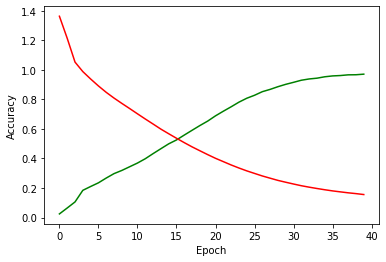

In [19]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['loss'],color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

5) Defining inference models
We create inference models which help in predicting answers.

Encoder inference model : Takes the question as input and outputs LSTM states ( h and c ).

Decoder inference model : Takes in 2 inputs, one are the LSTM states ( Output of encoder model ), second are the answer input seqeunces ( ones not having the <start> tag ). It will output the answers for the question which we fed to the encoder model and its state values.

In [14]:

def make_inference_models():
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = tf.keras.layers.Input(shape=(300,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(300,))

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    return encoder_model, decoder_model

6) Talking with our Chatbot

First, we define a method str_to_tokens which converts str questions to Integer tokens with padding.

In [15]:
def str_to_tokens(sentence: str):
    words = sentence.lower().split()
    words = sentence.translate(str.maketrans("", "", string.punctuation)).split()
    tokens_list = list()

    for word in words:
        if word in vocab:
            tokens_list.append(tokenizer.word_index[word])
        elif word == "quit":
            print("See ya!!")

        else:
            return str_to_tokens("understand")
            # reply =  "haha what??"
            # decoded_translation =
            # decoded_translation = "BOT :" + ''
            # #print("BOT : Can you eloborate the word {}.".format(word))
            break
    return preprocessing.sequence.pad_sequences([tokens_list], maxlen=maxlen_questions, padding='post')


- First, it takes a question as input and predict the state values using enc_model.
- Then, set the state values in the decoder's LSTM.
- Then, we generate a sequence which contains the <start> element.
- input this sequence in the dec_model.
- replace the <start> element with the element which was predicted by the dec_model and update the state values.
- carry out the above steps iteratively till we hit the <end> tag or the maximum answer length.

In [18]:
enc_model, dec_model = make_inference_models()


for _ in range(10):
    states_values = enc_model.predict( str_to_tokens( input( 'Enter question : ' ) ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation ='BOT : '+ ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( decoded_translation )

Enter question : hy
BOT :  what up bro end
Enter question : how are you
BOT :  i am doing well end
Enter question : what are you doing
BOT :  i was about to sleep wait i don't sleep never mind end
Enter question : haha
BOT :  the sort of active life hahha end
Enter question : what up
BOT :  my favorite subject is chemistry end
Enter question : who are you
BOT :  i am a bot end
Enter question : good
BOT :  you are a bad end
Enter question : who built you
BOT :  asmit shrestha end
Enter question : wow
BOT :  haha end
Enter question : i am hungry
BOT :  go and have some food end
